<a href="https://colab.research.google.com/github/advaitkumar3107/MoNuSeg/blob/master/MoNuSeg_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **UNET_DETECTION**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd
import keras
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
os.chdir('/content/drive/My Drive/amit sethi')

ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)

# Data Path
TEST_PATH = 'Datasets/test/'
TRAIN_PATH = 'Datasets/nucleus/'

# Get train and test IDs
test_ids = next(os.walk(TEST_PATH))[1]
train_ids = next(os.walk(TRAIN_PATH))[1]

from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Root directory of the project

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "/content/drive/My Drive/amit sethi/logs")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Using TensorFlow backend.


In [0]:
  def mean_iou(y_true, y_pred):
      prec = []
      for t in np.arange(0.5, 1.0, 0.05):
          y_pred_ = tf.compat.v1.to_int32(y_pred > t)
          score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
          K.get_session().run(tf.local_variables_initializer())
          with tf.control_dependencies([up_opt]):
              score = tf.identity(score)
          prec.append(score)
      return K.mean(K.stack(prec), axis=0)
    
  def get_ax(rows=1, cols=1, size=8):
      """Return a Matplotlib Axes array to be used in
      all visualizations in the notebook. Provide a
      central point to control graph sizes.
      
      Change the default size attribute to control the size
      of rendered images
      """
      _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
      return ax

In [0]:
unet_path = os.path.join(MODEL_DIR, "unet.h5")
mask_rcnn_path = os.path.join(MODEL_DIR, "mask_rcnn.h5")

In [0]:
X_test = np.zeros((len(test_ids), 128, 128, 3), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), 128, 128, 1), dtype=np.bool)
sizes_test = []
X_train = np.zeros((len(train_ids), 128, 128, 3), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), 128, 128, 1), dtype = np.bool)
sizes_train = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (128, 128), mode='constant', preserve_range=True)
    X_test[n] = img
    mask = np.zeros((128, 128, 1), dtype=np.bool)
    
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (128, 128), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_test[n] = mask

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    sizes_train.append([img.shape[0], img.shape[1]])
    img = resize(img, (128, 128), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((128, 128, 1), dtype=np.bool)
    
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (128, 128), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing test images ... 


100%|██████████| 24/24 [00:46<00:00,  2.43s/it]


In [0]:
unet = load_model(unet_path, custom_objects={'mean_iou': mean_iou})
preds_train = unet.predict(X_train, verbose = 1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_train_upsampled = []
for i in range(len(preds_train)):
  preds_train_upsampled.append(resize(np.squeeze(preds_train[i]),
                                      (sizes_train[i][0], sizes_train[i][1]),
                               mode = 'constant', preserve_range = True))
  
preds_test = unet.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


6/6 [==============================] - 0s 50ms/step


In [0]:
y_test = Y_test*1
y_train = Y_train*1

In [0]:
  def predictions(y_true, y_pred):
      corrects = []
      length = y_true.shape[0]
      height = y_true.shape[1]
      width = y_true.shape[2]
      total_points = height*width
      background_class = np.zeros((height, width))
      nucleus_class = np.ones((height, width))

      for i in np.arange(length):
        correct = np.array(y_true[i] == y_pred[i])
        incorrect = total_points - np.sum(correct*1)
        true_positive = 0
        true_negative = 0
        for j in np.arange(height):
          for k in np.arange(width):
            if (y_true[i][j][k] == y_pred[i][j][k]) and (y_true[i][j][k] == 1):
              true_positive = true_positive + 1
            elif (y_true[i][j][k] == y_pred[i][j][k]) and (y_true[i][j][k] == 0):
              true_negative = true_negative+1
        nucleus_iou = true_positive/(true_positive + incorrect)
        background_iou = true_negative/(true_negative + incorrect)
        mean = nucleus_iou/2 + background_iou/2
        corrects.append(mean)
      return corrects

In [0]:
score_test = predictions(y_test, preds_test_t)
score_train = predictions(y_train, preds_train_t)
avg_test = np.sum(score_test)/len(score_test)
avg_train = np.sum(score_train)/len(score_train)

In [0]:
print(avg_test)
print(avg_train)

0.7319809977715382
0.725936065494391


## **MASK_RCNN DETECTION**

In [0]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

os.chdir('/content/drive/My Drive/amit sethi')

ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)

# Data Path
TRAIN_PATH = 'Datasets/nucleus/'
TEST_PATH = 'Datasets/test/'

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Root directory of the project

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "/content/drive/My Drive/amit sethi/logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "/content/drive/My Drive/amit sethi/mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)






class ShapesConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MAX_INSTANCES = 400
    DETECTION_MIN_CONFIDENCE = 0
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nucleus

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    IMAGE_MIN_SCALE = 2.0
    MAX_GT_INSTANCES = 200
    MEAN_PIXEL = [47.49, 41.63, 51.28]
    POST_NMS_ROIS_INFERENCE = 2000
    POST_NMS_ROIS_TRAINING = 1000
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 800

    # set number of epoch
    STEPS_PER_EPOCH = 200

    # set validation steps 
    VALIDATION_STEPS = 50
    
class NucleusInferenceConfig(ShapesConfig):
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Don't resize imager for inferencing
    IMAGE_RESIZE_MODE = "pad64"
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7
config = NucleusInferenceConfig()
config.display()


class ShapesDataset(utils.Dataset):
    
    def load_shapes(self, mode):
        
        # Add classes
        self.add_class("shapes", 1, "nucleus")
        

        if mode == "train":  
            for n, id_ in enumerate(train_ids):
                if n < int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)
              
        if mode == "val":   
            for n, id_ in enumerate(train_ids):
                if n >= int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)      

    def load_image(self, image_id):
        
        info = self.image_info[image_id]
        info = info.get("id")
       
        path = TRAIN_PATH + info
        img = imread(path + '/images/' + info + '.png')[:,:,:3]
        img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
       
        return img

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        
        info = self.image_info[image_id]
        info = info.get("id")
        path = TRAIN_PATH + info
        number_of_masks = len(next(os.walk(path + '/masks/'))[2])
        mask = np.zeros([config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], number_of_masks], dtype=np.uint8)
        iterator = 0
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = resize(mask_, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
            mask[:, :, iterator] = mask_
            iterator += 1
            # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(number_of_masks-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
            
        # Map class names to class IDs.
        class_ids = np.ones((number_of_masks,), dtype=int)
        
        return mask, class_ids.astype(np.int32)






Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [0]:
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

# Load validation dataset
dataset = ShapesDataset()
dataset.load_shapes("val")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 3
Classes: ['BG', 'nucleus']


In [0]:
model_path = os.path.join(MODEL_DIR, "mask_rcnn.h5")

DEVICE = "/gpu:0"
with tf.device(DEVICE):
    nmodel = modellib.MaskRCNN(mode="inference",
                              model_dir=os.getcwd(),
                              config=inference_config)
    
nmodel.load_weights(mask_rcnn_path, by_name=True)

In [0]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = nmodel.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

KeyError: ignored

In [0]:
model_path = os.path.join(MODEL_DIR, "mask_rcnn.h5")

class ShapesConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nucleus

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 800

    # set number of epoch
    STEPS_PER_EPOCH = 200

    # set validation steps 
    VALIDATION_STEPS = 50

class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

DEVICE = "/gpu:0"
with tf.device(DEVICE):
    nmodel = modellib.MaskRCNN(mode="inference",
                              model_dir=os.getcwd(),
                              config=inference_config)
    
nmodel.load_weights(mask_rcnn_path, by_name=True)



# Run detection and predict nuclei on a patch
results = nmodel.detect([X_test[0]], verbose=1)
r = results[0]
visualize.display_instances(X_test[0], r['rois'], r['masks'],r['class_ids'],['BG', 'Nuclei'],
                      figsize=(16, 16), ax=None,
                      show_mask=False, show_bbox=False,
                      title="Predictions")

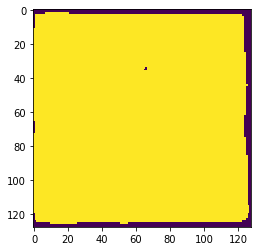

In [0]:
patch_size = 128

# Generate an n-ary nuclei mask 
individual_nuclei = r['masks']
predicted_nuclei = np.zeros((patch_size,patch_size), dtype = int)
n_nuc = 0
for k in range(individual_nuclei.shape[2]):
    n_nuc += 1
    nuc_mask = r['masks'][:,:,k]
    predicted_nuclei += (n_nuc)*nuc_mask
plt.imshow(predicted_nuclei)



In [0]:
res = r['rois']
res